In [4]:
.libPaths("C:/Program Files/R/R-3.3.0/library") # 라이브러리 설치 경로 설정


In [5]:
#library(readxl)
library(ggplot2)
library(gridExtra)
library(stringr)
library(dplyr)
library(tidyr)



Attaching package: 'dplyr'

The following object is masked from 'package:gridExtra':

    combine

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [6]:
glrvs <- guides(fill=guide_legend(reverse = TRUE), color=guide_legend(reverse = TRUE)) 

setwd("~/Project_timeSeriesAnalysis/data")

mungfile <- function(filename,date){ # date:string, "20160920"
        var_df <- read.csv(filename)
        # selDeleteLine = str_detect(var_df[,2], "[소총] 계")
        # var_df <- var_df[!selDeleteLine, ]
        # 9/22 MINOR MODIFICATION. REMOVED $DIST IN FUNCTION TO ACCOMODATE CONNMAX FILE. 
        # var_df$dist <- cut(var_df$TotPrbDLMax,breaks = seq(0,100, by=10),
        #                    labels = seq(10,100, by=10), include.lowest = TRUE)
        var_df$datetime <- str_c(date, var_df$time, sep=" ")
        var_df$datetime <- as.POSIXct(strptime(var_df$datetime,"%Y%m%d %H:%M", tz="GMT"))
        var_df$date <- date
        
        if(!is.null(var_df$CNUM))
                cellnum <- str_extract(var_df$CNUM, "\\d\\d?")
        if(!is.null(var_df$CELL_ID))
                cellnum <- str_extract(var_df$CELL_ID, "\\d\\d?")
        var_df$cellid <- str_c(var_df$eNB, cellnum, sep = "-")
        return(var_df)
}



In [7]:
convCSV2dataframes <- function(pref, option="all"){ #prefix of filename...
        lfiles <- list.files(pattern = str_c(pref,"\\d{8}"))
        if(option=="add"){
                lfiles <- lfiles[length(lfiles)]
        }
        for(file in lfiles){
                fdate <- str_extract(file, "\\d{8}")
                vdate <- str_sub(fdate,5)
                assign(str_c(pref, vdate), mungfile(file,fdate), 
                       envir = .GlobalEnv)
        }
}


convCSV2dataframes("prb5M")
convCSV2dataframes("conn5M")
convCSV2dataframes("conn1H")
convCSV2dataframes("prb1H")


In [8]:
# get  time series of each cell on a matrix..

# tmp_df <-prb5M0919 %>% filter(FREQUENCY=="800MHz") %>% 
#         select(cellid, date, time, TotPrbDLMax) %>% arrange(cellid,date,time)
# 
# dim(tmp_df)


mkMTX <- function(df, Freq, value){
        value_index <-which(colnames(df)==value)
        #realName <- colnames(df)[value_index]
        colnames(df)[value_index] <- "value"
        tmp_df <- df %>% filter(FREQUENCY==Freq) %>% 
                select(cellid, date, time, value) %>% 
                arrange(cellid,date,time)
        
        mtx <- matrix(data=tmp_df$value,nrow=nrow(tmp_df)/12,ncol=12, byrow=TRUE)
        rownames(mtx) <- tmp_df$cellid[c(T,rep(F,11))]
        return(mtx)
}

mtx0919max <- mkMTX(prb5M0919, "800MHz", "TotPrbDLMax")
mtx0920max <- mkMTX(prb5M0920, "800MHz", "TotPrbDLMax")
mtx0921max <- mkMTX(prb5M0921, "800MHz", "TotPrbDLMax")

mtx0919avg <- mkMTX(prb5M0919, "800MHz", "TotPrbDLAvg")
mtx0920avg <- mkMTX(prb5M0920, "800MHz", "TotPrbDLAvg")
mtx0921avg <- mkMTX(prb5M0921, "800MHz", "TotPrbDLAvg")

maxoveravg <- mtx0919max/mtx0919avg

# plot(seq(5,60, by=5),mtx0919max[1,],type="l")
# plot(mtx0919max[,])


# make a 3-d array: cellid, time, date: value...

arr_PDmax <- array(0, c(dim(mtx0919max)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919max),NULL, NULL))

arr_PDmax[,,1] <- mtx0919max
arr_PDmax[,,2] <- mtx0920max
arr_PDmax[,,3] <- mtx0921max

arr_PDavg <- array(0, c(dim(mtx0919max)[1], 12, 5), 
                   dimnames = list(rownames(mtx0919avg),NULL, NULL))

arr_PDavg[,,1] <- mtx0919avg
arr_PDavg[,,2] <- mtx0920avg
arr_PDavg[,,3] <- mtx0921avg


In [9]:

# Get Insight to select right samples...

head(arr_PDmax[,,1])
head(apply(arr_PDmax[,,1],1,function(x) sum(x > 80)))

[,1]  [,2]  [,3]  [,4]  [,5]  [,6]  [,7]  [,8]  [,9] [,10] [,11]
1-17097-0   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
1-17097-1  99.81 96.06 94.76 97.14 96.06 97.26 37.30 99.37 98.19 26.71 62.55
1-17097-10 99.28 99.16 95.61 98.58 96.86 98.96 99.33 99.19 98.94 98.98 98.87
1-17097-11 97.11 42.22 97.87 79.17 98.25 97.70 98.78 98.32 71.51 91.57 89.37
1-17097-2  89.76 88.80 75.20 46.89 94.33 62.98 88.95 66.93 96.81 96.83 96.78
1-17097-9   0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
           [,12]
1-17097-0   0.00
1-17097-1  89.87
1-17097-10 98.96
1-17097-11 99.05
1-17097-2  99.22
1-17097-9   0.00

1-17097-0  1-17097-1 1-17097-10 1-17097-11  1-17097-2  1-17097-9 
         0          9         12          9          8          0

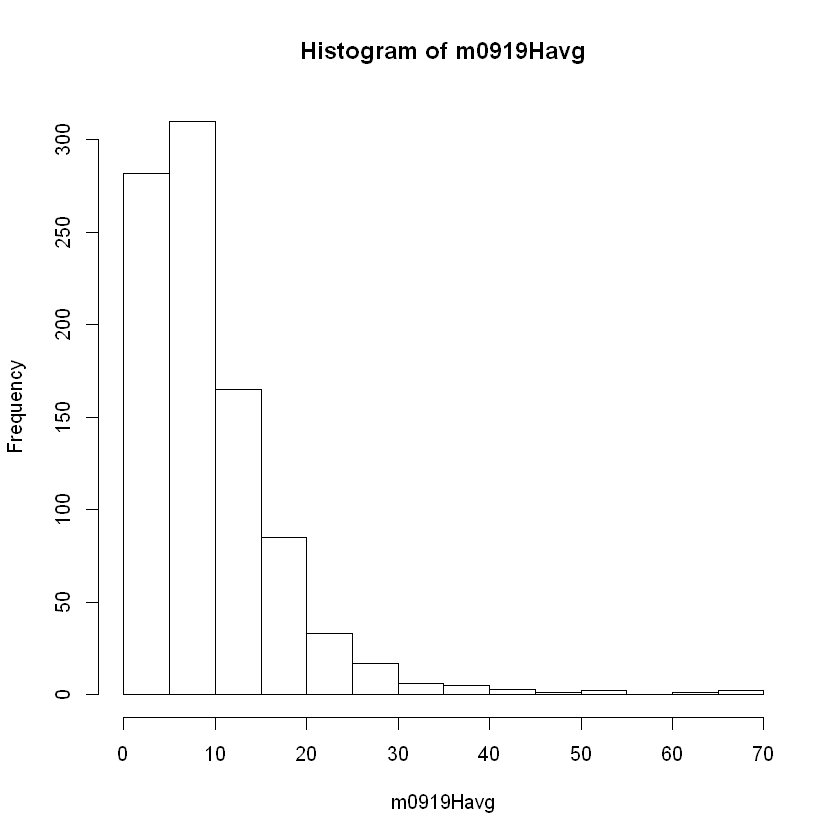

In [10]:
m0919Havg <- apply(mtx0919avg, 1, mean)

hist(m0919Havg)

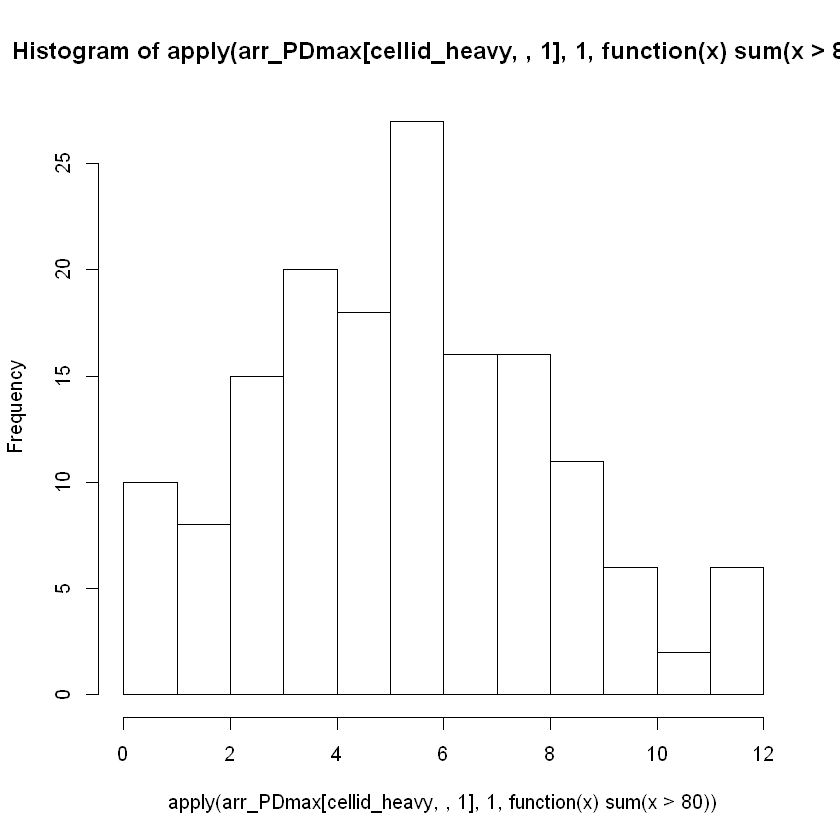

In [11]:

tmp_mtx <-m0919Havg[m0919Havg > 15]
cellid_heavy <- attr(tmp_mtx,"names")
hist(apply(arr_PDmax[cellid_heavy,,1],1, function(x) sum(x > 80)))

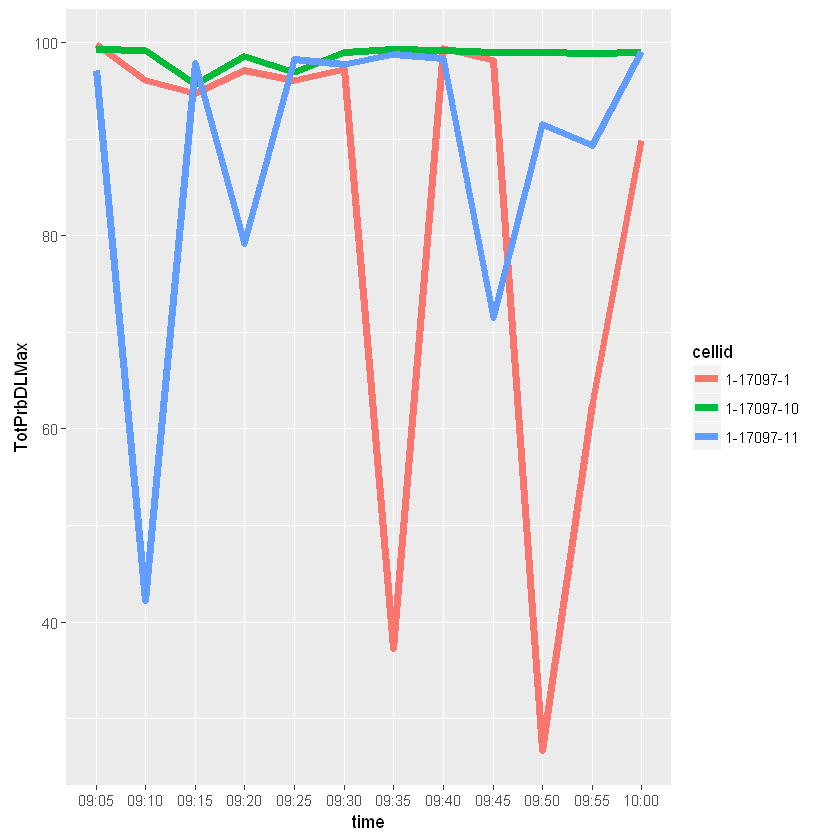

In [12]:
ggplot(prb5M0919 %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,TotPrbDLMax,color=cellid, group=cellid)) + geom_line(size=2) 

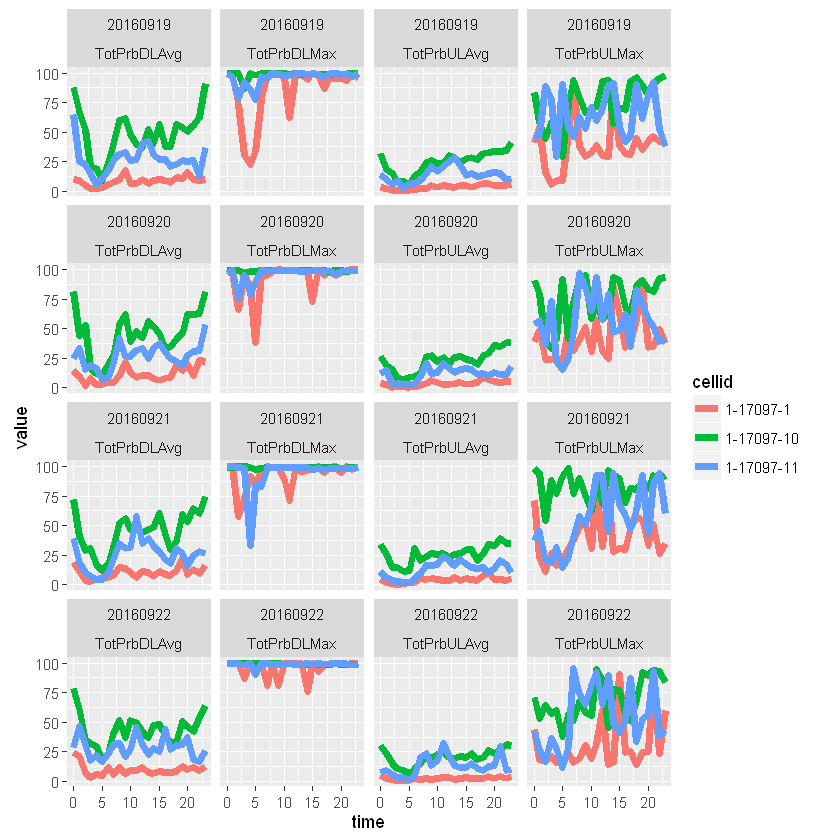

In [13]:
###############  hourly Trend 00:00 ~ 24:00 ########
###### PRB ########
varList <-ls(pattern = "prb1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
prb1HTot <- do.call(rbind, var_list)

selCol <- which(str_detect(colnames(prb1HTot),"Avg|Max"))

prb1HTot.gr <- gather(prb1HTot, "key", "value", selCol) %>% 
        select(cellid, FREQUENCY, date, time, key, value)

selKey <- c("TotPrbDLAvg", "TotPrbDLMax", "TotPrbULAvg", "TotPrbULMax")
ggplot(prb1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3] & key %in% selKey),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=length(selKey))


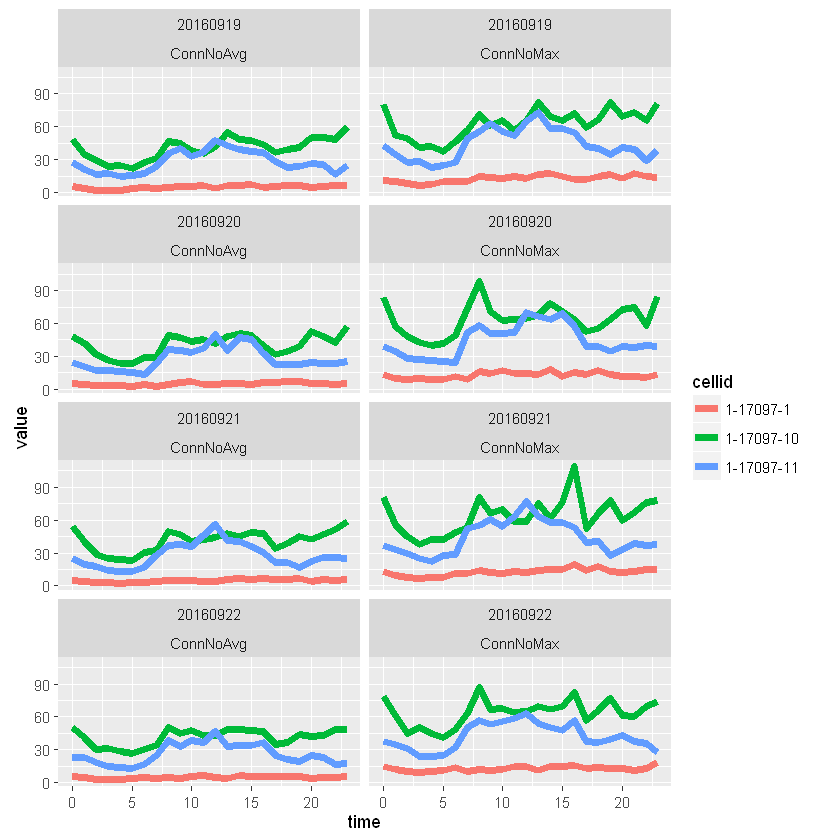

In [14]:
###### CONNMAX #####
varList <-ls(pattern = "conn1H\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
conn1HTot <- do.call(rbind, var_list)

conn1HTot.gr <- gather(conn1HTot, "key", "value", c(5,6)) %>% 
                  select(cellid, FREQUENCY, date, time, key, value)


ggplot(conn1HTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)

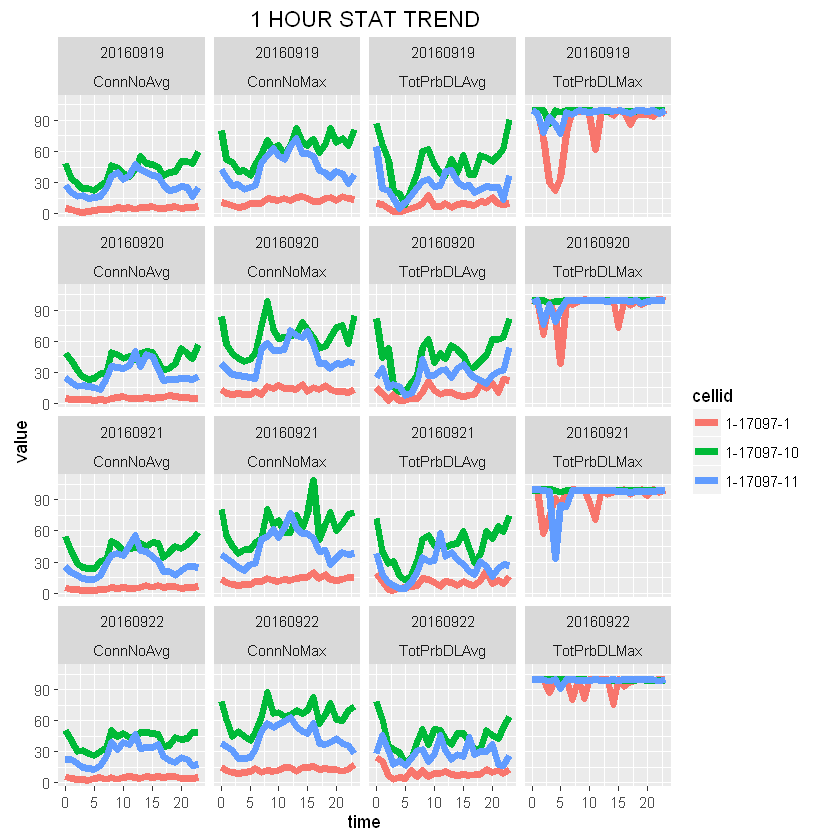

In [15]:
####### combind result 
combind1H.gr <- rbind(prb1HTot.gr, conn1HTot.gr)
selKey <- c("TotPrbDLAvg", "TotPrbDLMax", "ConnNoAvg", "ConnNoMax")
ggplot(combind1H.gr %>% filter(cellid %in% cellid_heavy[1:3] & key %in% selKey),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=4) + ggtitle("1 HOUR STAT TREND")


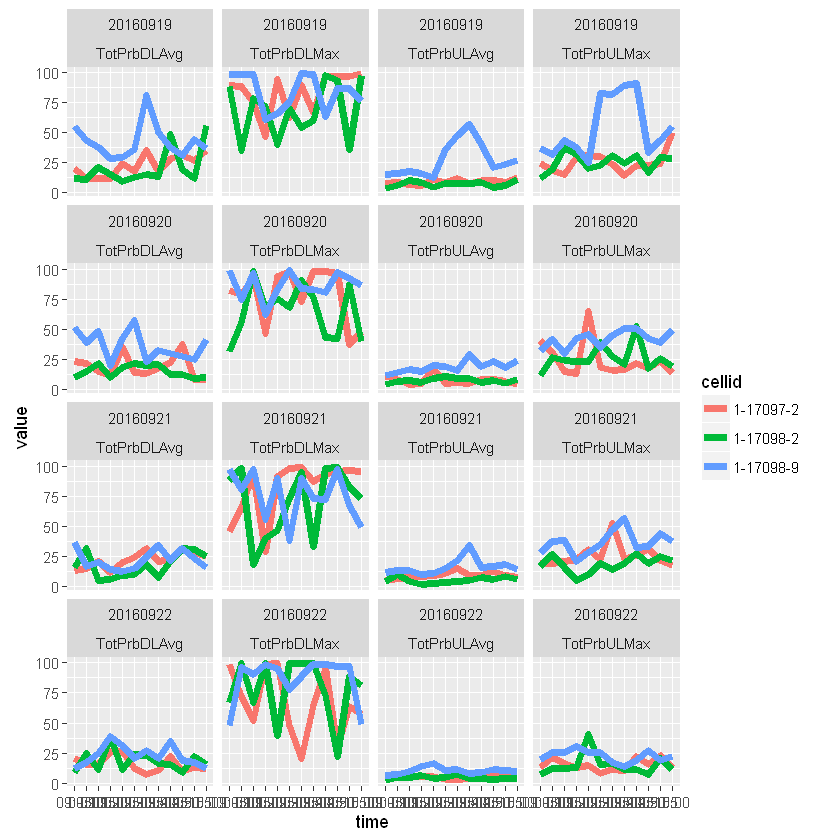

In [16]:
################ 5 Minute Data Trend in 9:00-10:00  #########
### PRB ########
varList <-ls(pattern = "prb5M\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
prb5MTot <- do.call(rbind, var_list)

selCol <- which(str_detect(colnames(prb1HTot),"Avg|Max"))
prb5MTot.gr <- gather(prb5MTot, "key", "value", selCol) %>% 
        select(cellid, FREQUENCY, date, time, key, value)
    
selKey <- c("TotPrbDLAvg", "TotPrbDLMax", "TotPrbULAvg", "TotPrbULMax")    
ggplot(prb5MTot.gr %>% filter(cellid %in% cellid_heavy[4:6]& key %in% selKey),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=length(selKey))

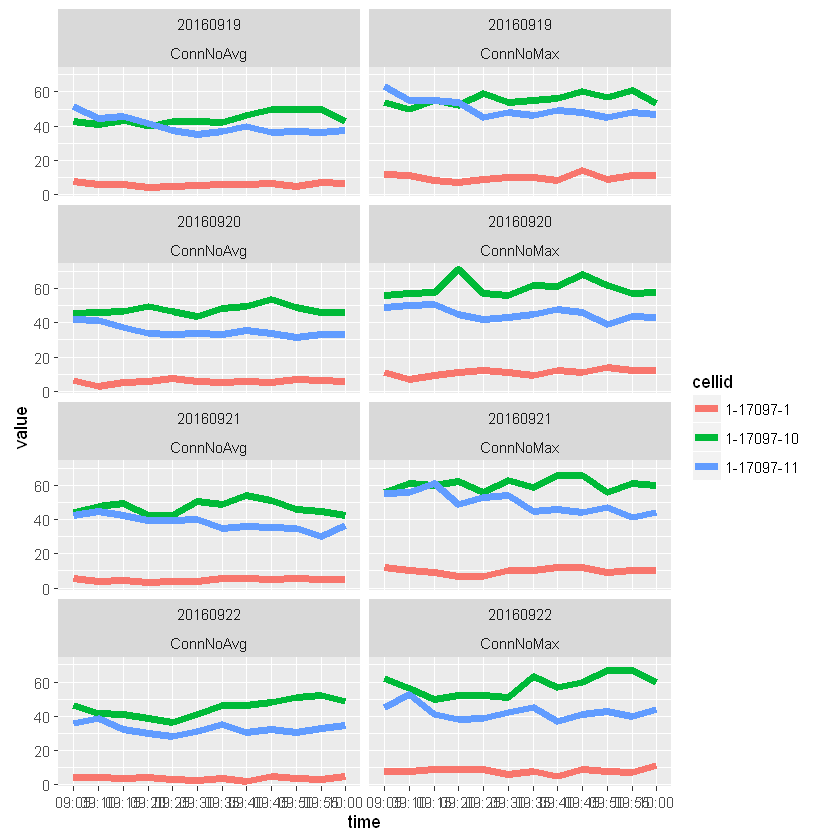

In [17]:
######## CONNMAX ##########
varList <-ls(pattern = "conn5M\\d{4}$")
var_list <- lapply(varList, function(x) eval(parse(text = x)) )
conn5MTot <- do.call(rbind, var_list)

conn5MTot.gr <- gather(conn5MTot, "key", "value", c(5,6)) %>% 
        select(cellid, FREQUENCY, date, time, key, value)


ggplot(conn5MTot.gr %>% filter(cellid %in% cellid_heavy[1:3]),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=2)


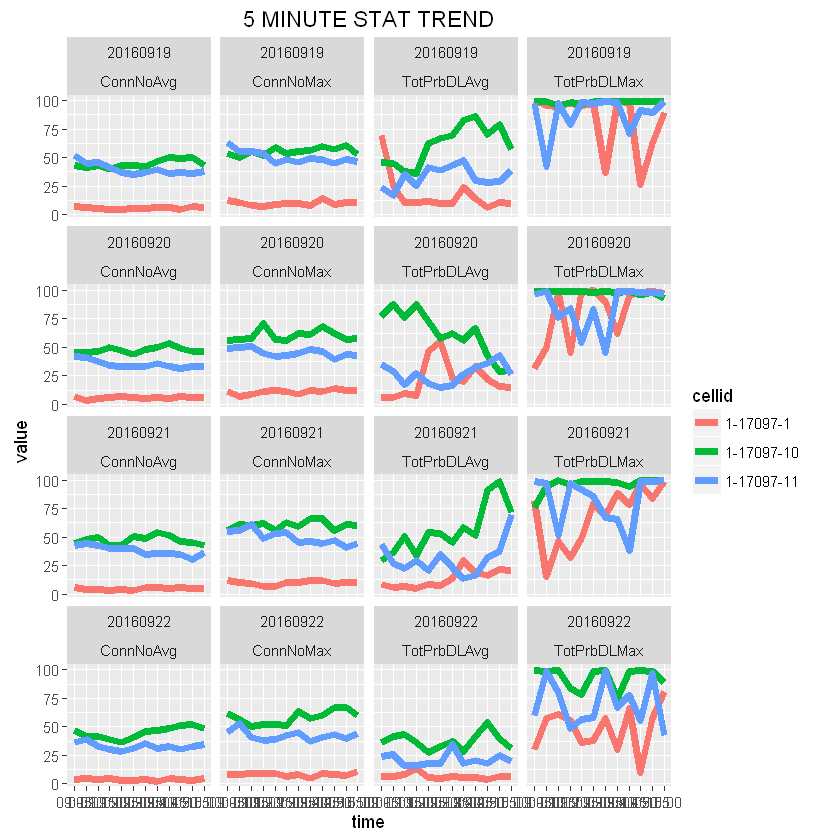

In [18]:
####### combind results
combind5M.gr <- rbind(prb5MTot.gr, conn5MTot.gr)

selKey <- c("TotPrbDLAvg", "TotPrbDLMax", "ConnNoAvg", "ConnNoMax")
ggplot(combind5M.gr %>% filter(cellid %in% cellid_heavy[1:3] & key %in% selKey),
       aes(time,value,color=cellid, group=cellid)) + geom_line(size=2) +
        facet_wrap(~date+key, ncol=4) + ggtitle("5 MINUTE STAT TREND")

Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend



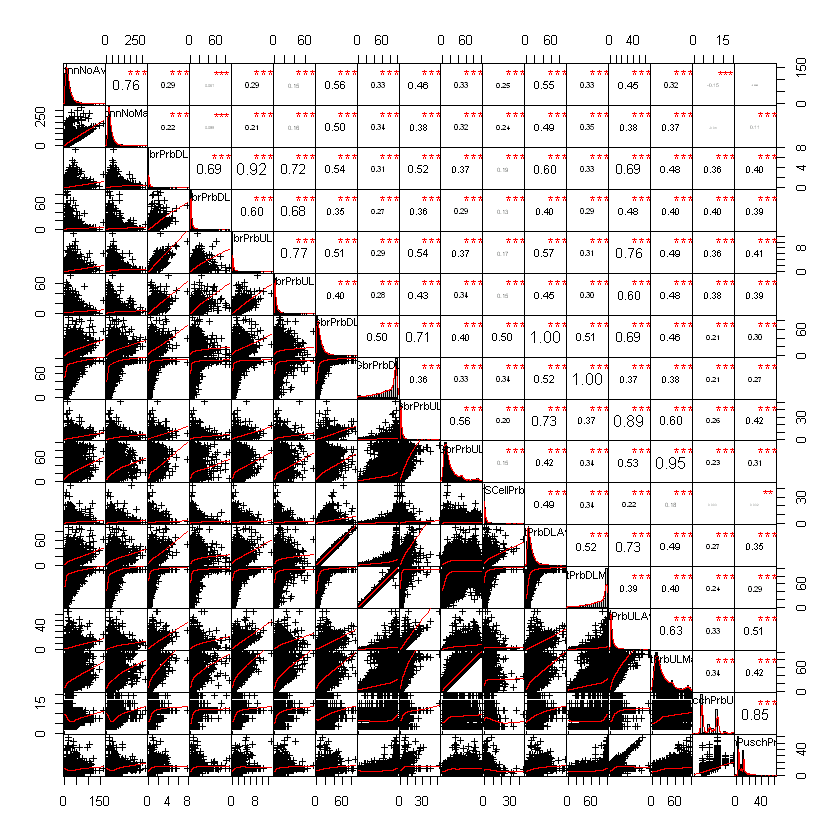

In [19]:
############
library(PerformanceAnalytics)
options(warn = -1)

combind1H <- spread(combind1H.gr, key, value)

active <- combind1H %>% group_by(FREQUENCY,cellid) %>% 
        summarize(mConnNoAvg = mean(ConnNoAvg)) %>% arrange(-mConnNoAvg) %>% 
        filter(mConnNoAvg > 0.5)
activeList <- active$cellid

combind1H <- combind1H %>% filter(cellid %in% activeList)

randRows <- sort(sample.int(nrow(combind1H), 10000))
chart.Correlation(combind1H[randRows,5:21], histogram=TRUE, pch="+")

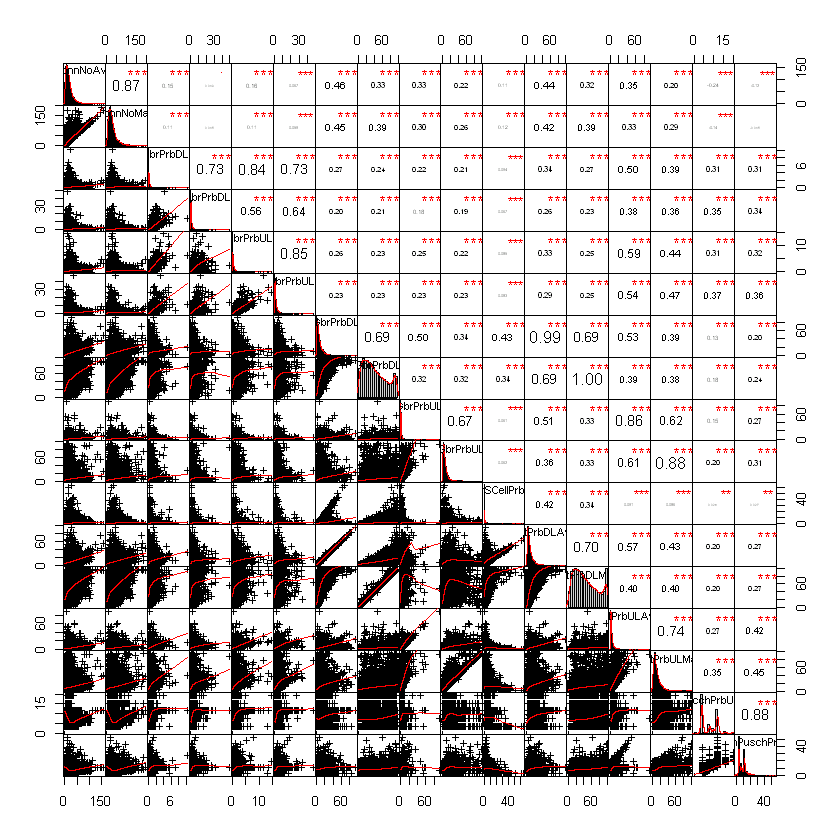

In [20]:
############
combind5M <- spread(combind5M.gr, key, value) %>% filter(cellid %in% activeList)

randRows <- sort(sample.int(nrow(combind5M), 10000))
chart.Correlation(combind5M[randRows,5:21], histogram=TRUE, pch="+")

#chart.Correlation(combind5M[10000:20000,5:8], histogram=TRUE, pch="+")
#chart.Correlation(combind5M[20000:30000,5:8], histogram=TRUE, pch="+")

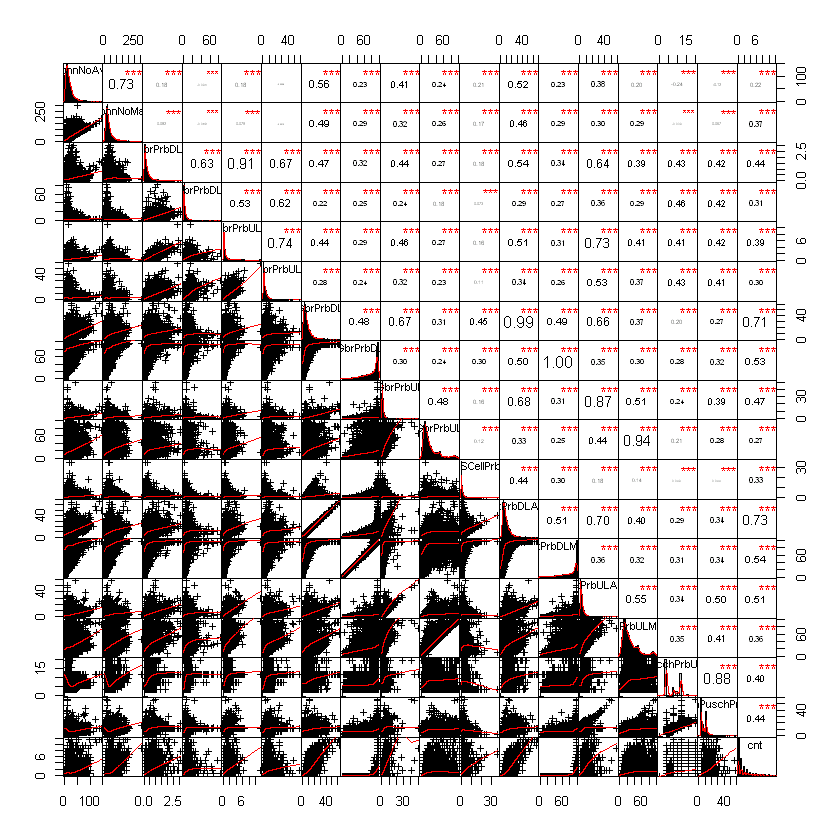

In [21]:

# 시간대별로 5분 단위의 PrbDLMax값이 90 이상인 횟수가 많다면 셀 커버리지 조정 필요성 고려...
# 확보한 9- 10시대의 5분 단위 데이터를 분석... 1시간 동안 위의 조건을 만족하는 횟수를 구해서
# 시간 단위 통계와 관계 도출...

# 시간당 5분단위 PrbDLMax > 90 카운트수. 시간단위 통계가 됨.(9-10시 밖에 없음)
# 시간 단위의 다른 변수들과 correlation을 구해서 해당 변수로 대치... 
# 가장 correlation이 높은 것은 TotPrbDLAvg이다...
# connNoAvg는 연관성이 상대적으로 줄어든다...

cnt <-function(x, cutoff){
        sum(x > cutoff)
}

tmpdf <- combind5M %>% group_by(FREQUENCY, cellid, date) %>% 
        summarise(cnt = cnt(TotPrbDLMax,90)) %>% arrange(FREQUENCY,cellid)
tmpdf.1H <-combind1H %>% filter(time==9)  %>% arrange(FREQUENCY,cellid)
tmpdf.1H.1 <-cbind(tmpdf.1H, tmpdf[4])

# 9:00-10:00 시간대 변수들의 상관관계.. 5분단위 TotPrbDLMax >90 인 횟수를 나타내는 신규변수 포함.
chart.Correlation(tmpdf.1H.1[,5:22], histogram=TRUE, pch="+")



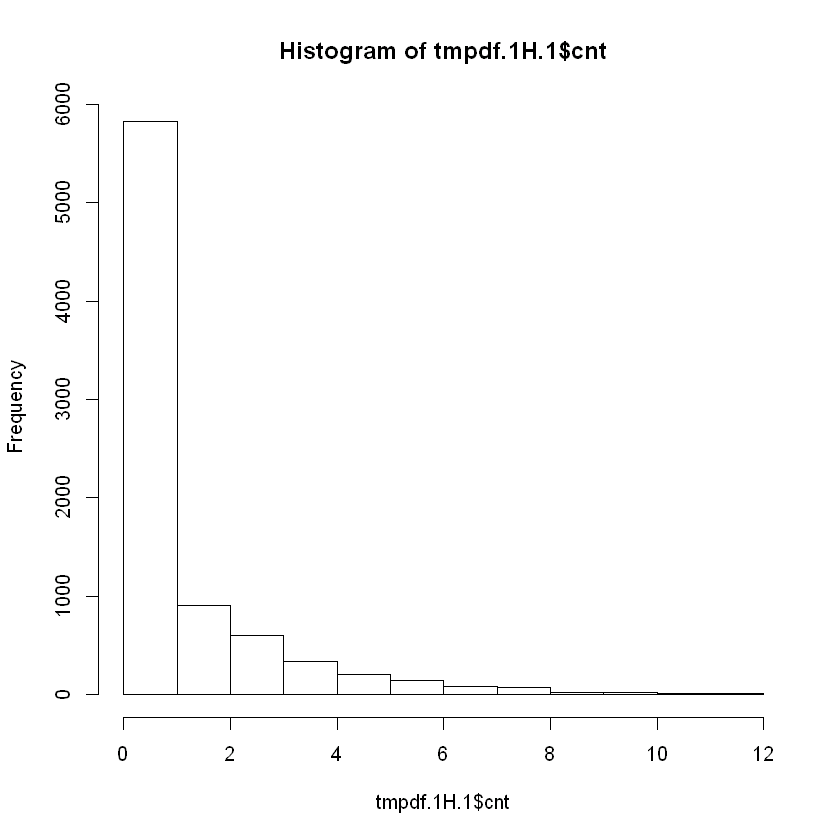

In [22]:
hist(tmpdf.1H.1$cnt)

In [23]:
with(tmpdf.1H.1, cor(TotPrbDLAvg, cnt))

[1] 0.7299054

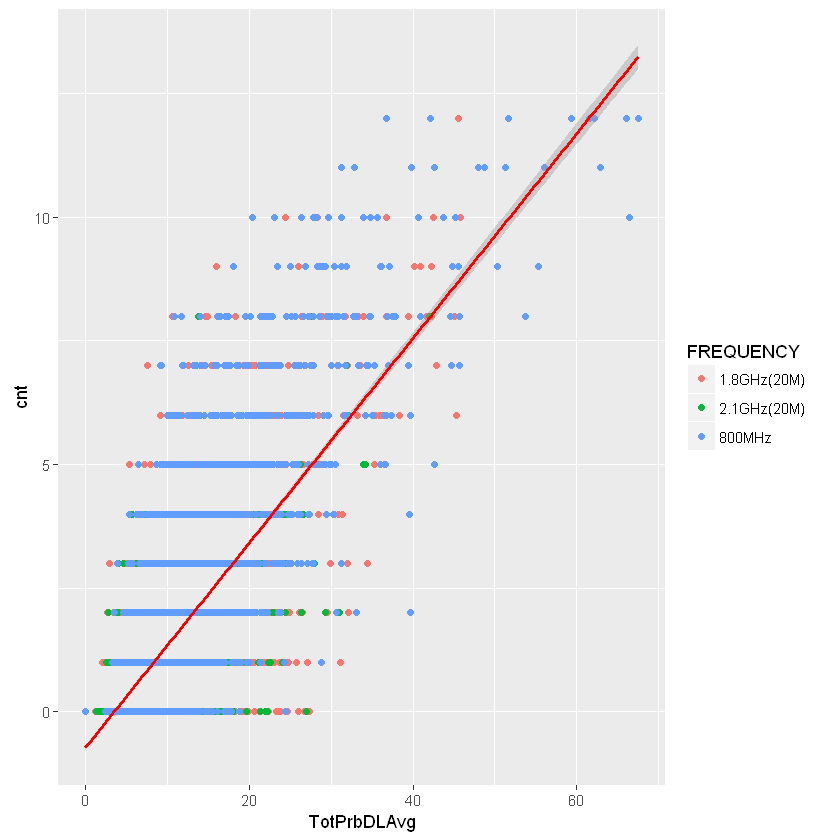

In [24]:

ggplot(tmpdf.1H.1, aes(TotPrbDLAvg, cnt, color=FREQUENCY)) + 
        geom_point()+ stat_smooth(method = "lm", col = "red")

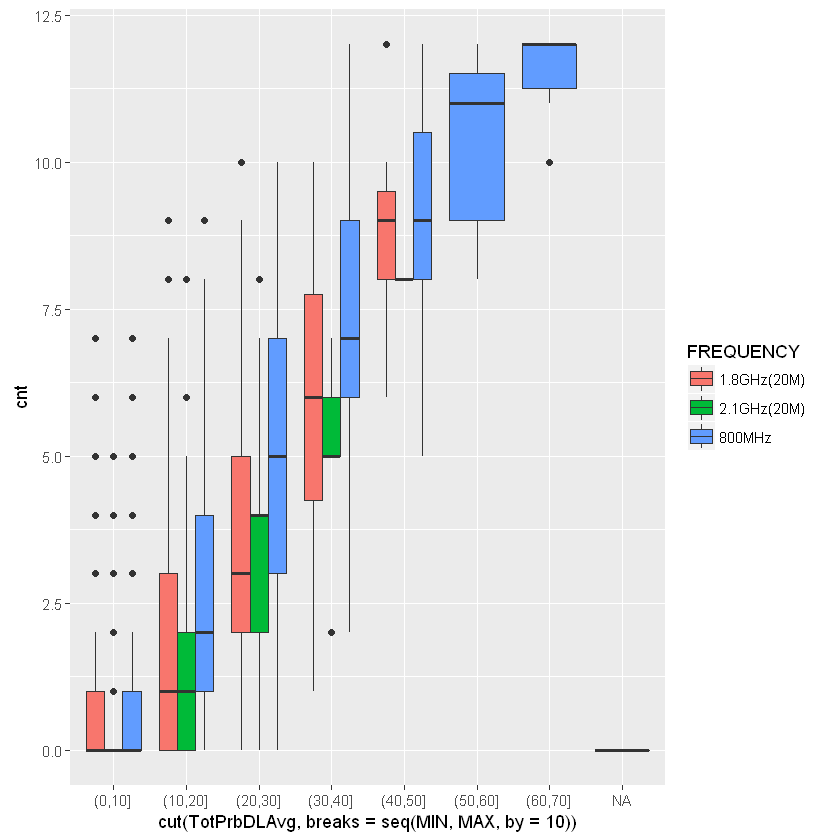

In [25]:
MIN <- floor(min(tmpdf.1H.1$TotPrbDLAvg)/10) *10
MAX <- ceiling(max(tmpdf.1H.1$TotPrbDLAvg)/10) * 10

ggplot(tmpdf.1H.1, aes(cut(TotPrbDLAvg, breaks= seq(MIN, MAX, by=10)), cnt)) + 
        geom_boxplot(aes(fill=FREQUENCY),position = "dodge", na.rm = T)



In [26]:

##################

# find the characteristics which occurs daily...
# and some difference could be distinguished 

#combind5M[1:1000,] %>% group_by(cellid,date) %>% summarise_each(funs(mean, max,which.max), matches("Avg|Max"))

# consider qcc algorithm...

##################



sgm <- function(x){
        return(sqrt(var(x)))
}

interleave <- function(v1,v2)
{
        ord1 <- 2*(1:length(v1))-1
        ord2 <- 2*(1:length(v2))
        c(v1,v2)[order(c(ord1,ord2))]
}

#평균적인 하루 데이터를 만드는 것임...

mkstoavg <- function(df){
        df <- df %>% group_by(FREQUENCY, cellid, time) %>% 
                summarise_each(funs(mean,sgm), matches("Avg"))
        # easy to compare with mean, sgm...
        idx <- (ncol(df) - 3)/2 +3
        df <- df[ ,c(1:3,  interleave(4:idx, (idx+1):ncol(df)))]
        return(df)
}


stoavg1H <- mkstoavg(combind1H)

# find feature's max hour  (connNo, PrbDL)
# 24시간 데이터일 경우 개별 변수의 일별 최고치 및 최고 시간대..
# max, which.max


changeFeatureName <- function(featureNames, featureString, postfix){
        featureS <- str_c(featureString, postfix, sep = "_")
        col_index <- which(featureNames == featureS)
        featureNames[col_index]= postfix
        return(featureNames)
}


rechangeFeatureName <- function(featureNames, featureString, postfix){
        col_index <- which(featureNames == postfix)
        featureS <- str_c(featureString, postfix, sep = "_")
        featureNames[col_index]= featureS
        return(featureNames)
}

mkMssmF <- function(tmpdf, featureString){
        colnames(tmpdf) <- changeFeatureName(colnames(tmpdf),featureString,"mean_sgm" )
        colnames(tmpdf) <- changeFeatureName(colnames(tmpdf),featureString,"sgm_mean" )
        
        tmpdf <- tmpdf %>% mutate(mssmF=mean_sgm/sgm_mean) 
        
        colnames(tmpdf) <- rechangeFeatureName(colnames(tmpdf),featureString,"mean_sgm" )
        colnames(tmpdf) <- rechangeFeatureName(colnames(tmpdf),featureString,"sgm_mean" )
        colnames(tmpdf) <- rechangeFeatureName(colnames(tmpdf),featureString,"mssmF" )
        return(tmpdf)
}



In [27]:

# temporary funciton for transforming index to time(hour)...
which.hour <- function(x){
        which.max(x)-1
        
}
mkCellStat <- function(df=stoavg1H, featureString="ConnNoAvg|TotPrbDLAvg" ){
        # df= stoavg1H... features="Conn|TotPrbDL"
        colStrings <- str_c("FREQ|cellid|time",featureString, sep = "|")
        selidx <- grepl(colStrings, colnames(df))
        df <- df[,selidx]
        
        df_group <- df %>% group_by(FREQUENCY, cellid) 
        
        df.1 <- df_group %>% 
                summarise_each(funs(max,which.hour), matches("mean")) 
        
        df.2 <- df_group %>% summarise_each(funs(mean,sgm),matches("Avg"))
        
        for( feature in unlist(str_split(featureString, "\\|")) ) {
                df.2 <- mkMssmF(df.2, feature)
        }

        df.out <- merge(df.1, df.2)
        return(df.out)
}


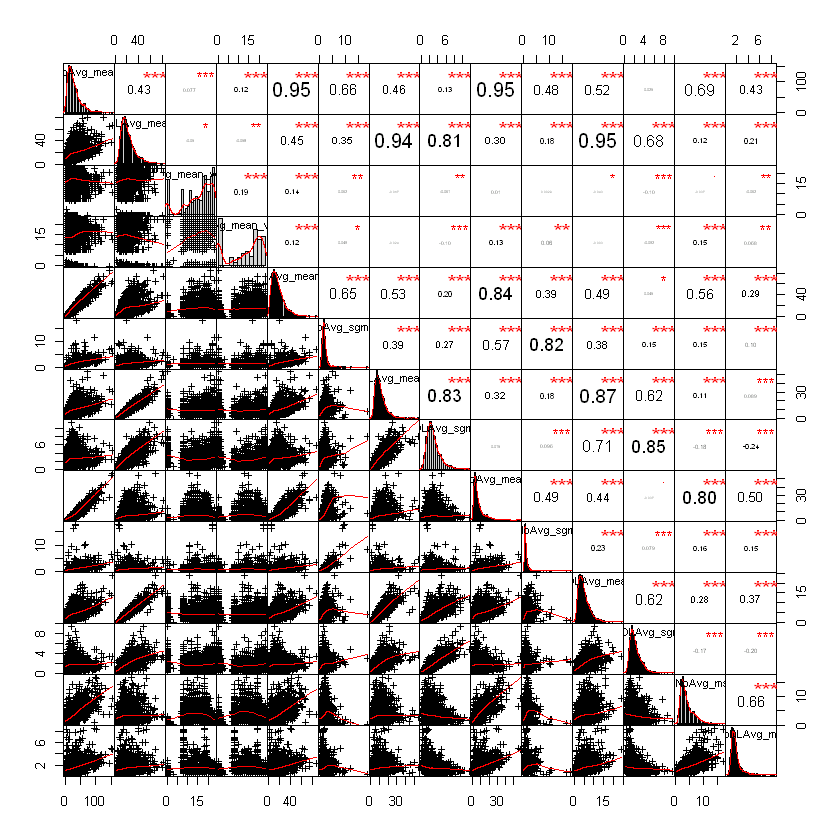

In [28]:

stat1H <- mkCellStat()
chart.Correlation(stat1H[ ,3:length(stat1H)], histogram=TRUE, pch="+")



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


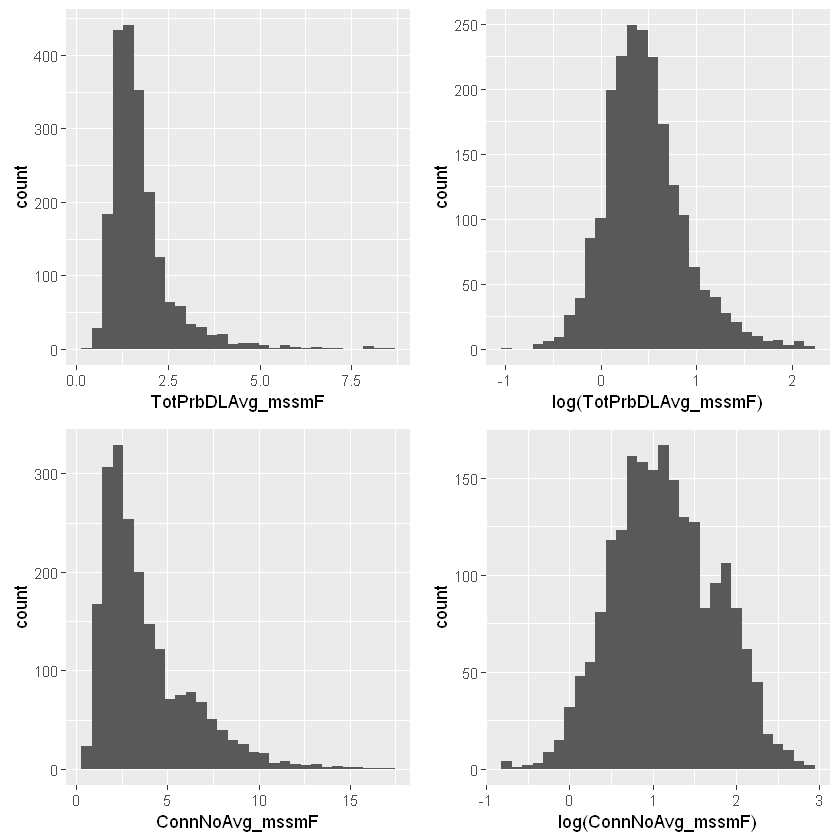

In [29]:

plot.1 <-ggplot(stat1H, aes(TotPrbDLAvg_mssmF)) + geom_histogram()
plot.2 <-ggplot(stat1H, aes(log(TotPrbDLAvg_mssmF))) + geom_histogram()

plot.3 <-ggplot(stat1H, aes(ConnNoAvg_mssmF)) + geom_histogram()
plot.4 <-ggplot(stat1H, aes(log(ConnNoAvg_mssmF))) + geom_histogram()
        
        
grid.arrange(plot.1, plot.2, plot.3, plot.4, ncol=2)


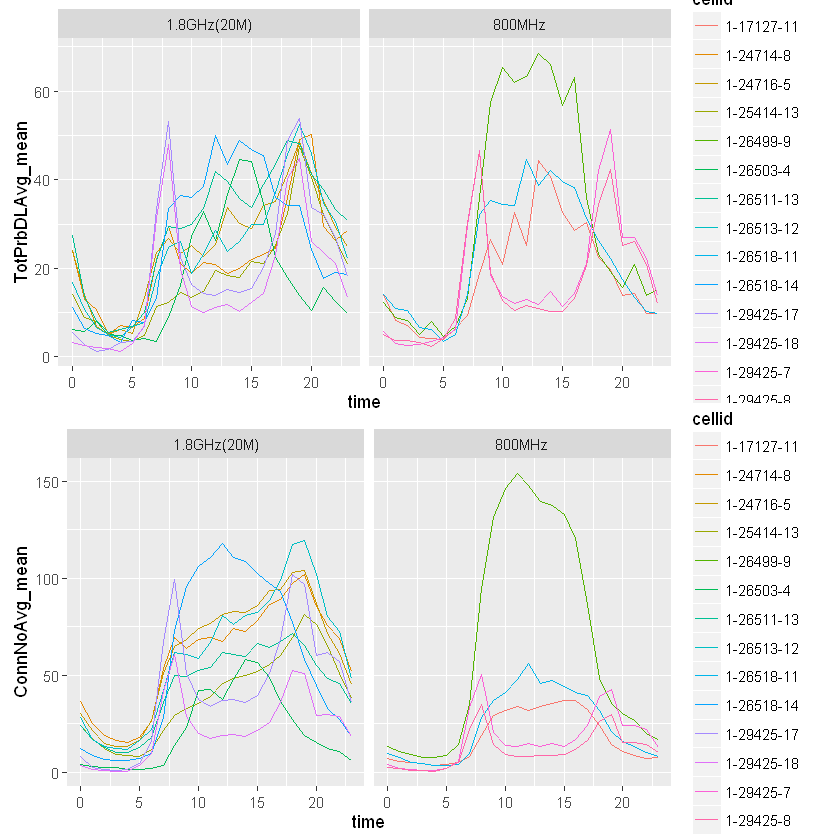

In [30]:
# select cell using variable condition....

selGrp <- function(stat1H,featureString,cutoff){
        
        idx <- which(colnames(stat1H) == featureString)
        colnames(stat1H)[idx] <- "feature" 
        cutoffValue <- quantile(stat1H$feature, cutoff)
        seldf <- stat1H %>% filter(feature > cutoffValue )
        seldf$cellid
}

cellList <- intersect(selGrp(stat1H, "TotPrbDLAvg_mean_max", 0.95), 
            selGrp(stat1H, "ConnNoAvg_mssmF", 0.95))

plot1 <- ggplot(stoavg1H %>% filter(cellid %in% cellList),  
        aes(x=time, y= TotPrbDLAvg_mean,color=cellid, group=cellid)) +
        geom_line() + facet_wrap(~FREQUENCY) 

plot2<- ggplot(stoavg1H %>% filter(cellid %in% cellList),  
        aes(x=time, y= ConnNoAvg_mean, color=cellid, group=cellid)) +
        geom_line() + facet_wrap(~FREQUENCY) 

grid.arrange(plot1, plot2, ncol=1)



In [31]:
library(mapproj)
library(ggmap)  
cellLoc <-read.csv("coordi.csv")
# 중복된 데이터가 존재함. 한셀이 여러 좌표를 가지고 있음.
# > nrow(cellLoc)
# [1] 2191
# > nrow(cellLoc[!duplicated(cellLoc),])
# [1] 2185
# > nrow(cellLoc[!duplicated(cellLoc[,c(1,2)]),])
# [1] 2155
# 주파수와 cell_id가 동일한 값들이 존재해서 중복 제거...  주파수와 cell_id가 같으면서도 좌표는 다른 값들도 존재..
cellLoc <- cellLoc[!duplicated(cellLoc[,c(1,2)]),] 

kor.1 <- get_map(location = c(lon = mean(cellLoc$lon), lat = mean(cellLoc$lat)),
                 maptype = "roadmap", source = "google" ,  zoom = 14)
p.1 <- ggmap(kor.1 ) 

#p.1 + geom_point(data=cellLoc %>% filter(str_detect(FREQUENCY,"800")), aes(lon, lat))

stat1H.1 <-merge(stat1H, cellLoc, by=c("FREQUENCY", "cellid"))

# 불일치하는 데이터가 많이 있음. CMS와 주파수 같은 것을  맞추니 셀 숫자가 25% 줄음...


stoavg1H.1 <- merge(stoavg1H, cellLoc,by=c("FREQUENCY", "cellid"))




stoavg1H.1$PrbDL_level <- cut(stoavg1H.1$TotPrbDLAvg_mean, labels = str_c("level",1:4),
    breaks=quantile(stoavg1H.1$TotPrbDLAvg_mean,0.25* 0:4))

PrbDLColors <- c("green","blue", "red", "black")   
names(PrbDLColors) <- levels(stoavg1H.1$PrbDL_level)
colScalePrbDL <- scale_colour_manual(name = "PrbDL",values = PrbDLColors)

showGeoDistatTime<- function(timeH, freq, cellList=stoavg1H.1$cellid){ 
        plot1 <-p.1 +  geom_point(data=stoavg1H.1 %>% 
                               filter(str_detect(FREQUENCY,freq), time == timeH, cellid %in% cellList), 
                          aes(lon, lat, color=PrbDL_level), size=1, alpha=0.5) + 
                colScalePrbDL +
                ggtitle(str_c(timeH, ":00~", timeH+1, ":00" ))
        plot1
} 


Loading required package: maps

 # maps v3.1: updated 'world': all lakes moved to separate new #
 # 'lakes' database. Type '?world' or 'news(package="maps")'.  #


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=37.588094,127.066465&zoom=14&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


In [32]:
nrow(stat1H)

[1] 2059

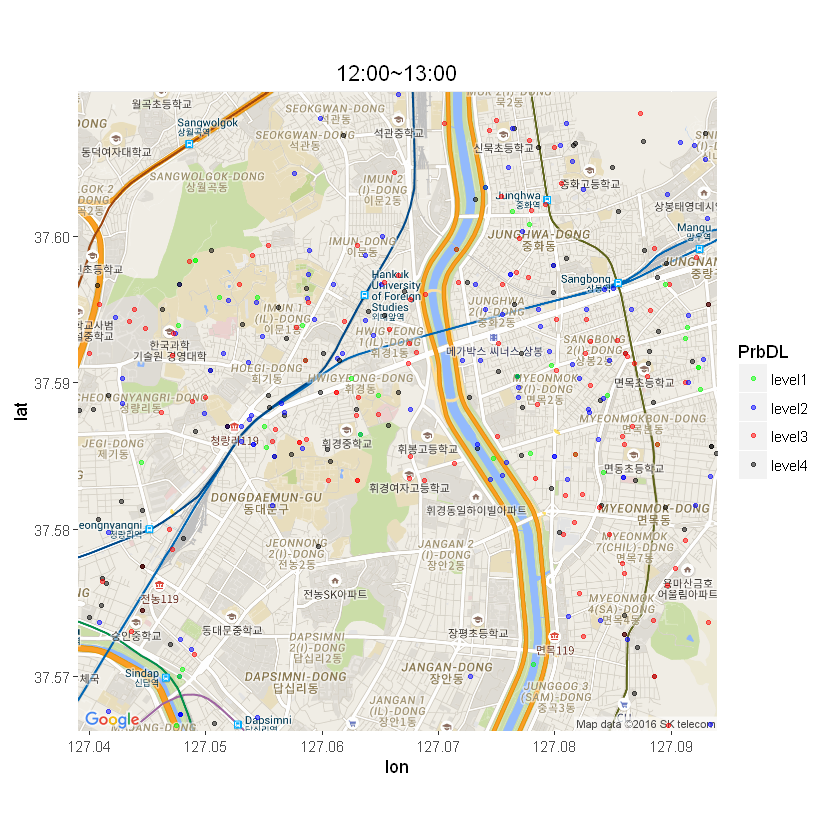

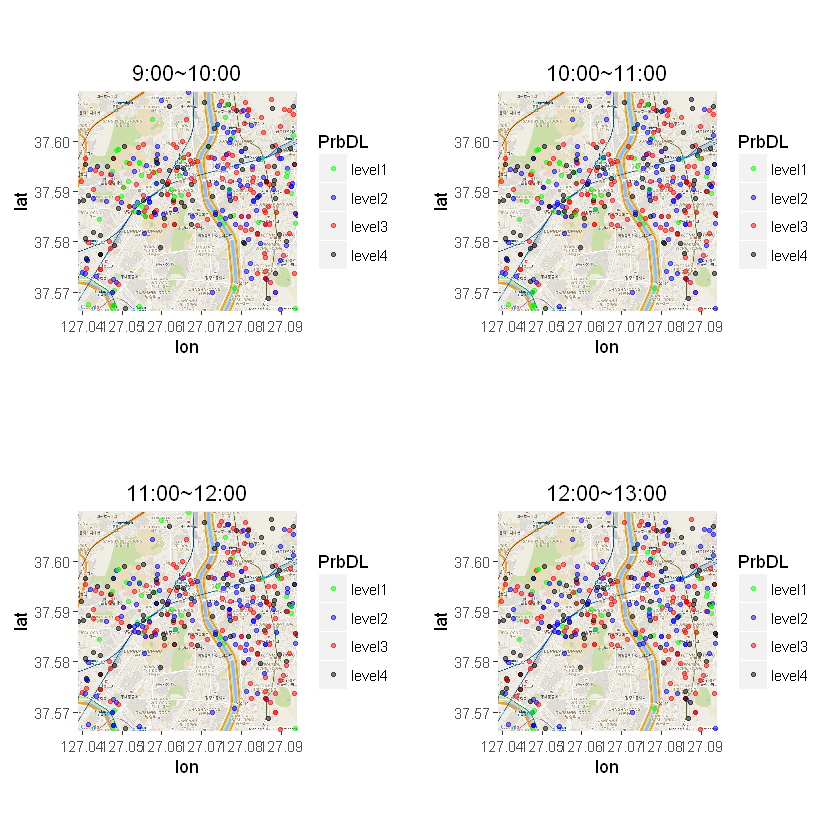

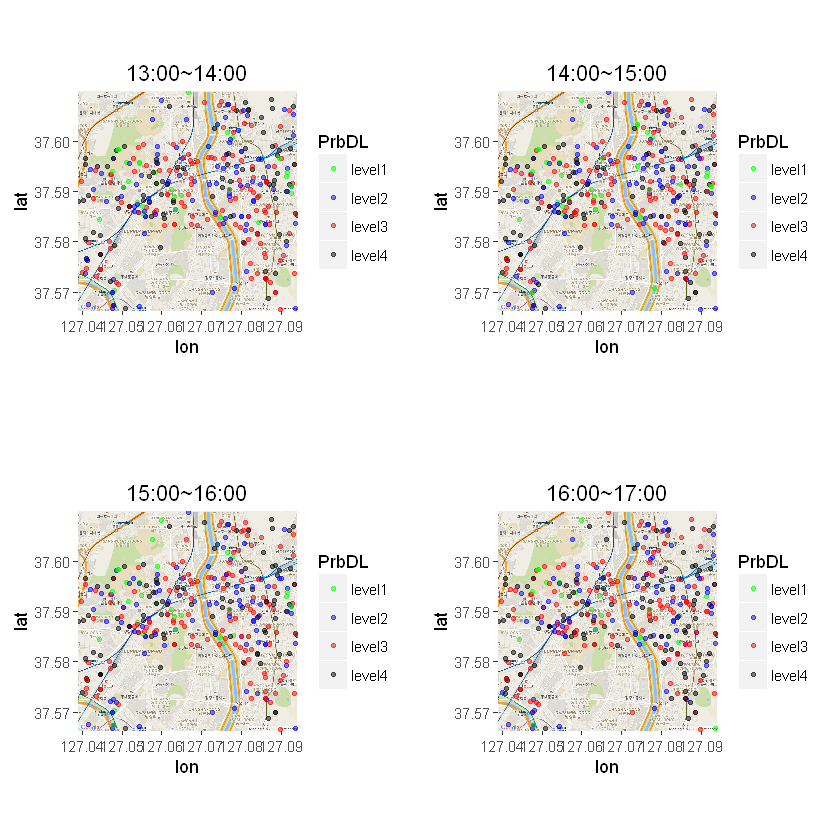

In [33]:

# for all cells...
showGeoDistatTime(12, "800")

plot.H <- list()
for(i in 1:8){
        plot.H[[i]] <- showGeoDistatTime(i+8, "800")
}
grid.arrange(plot.H[[1]],plot.H[[2]],plot.H[[3]],plot.H[[4]],ncol=2)
grid.arrange(plot.H[[5]],plot.H[[6]],plot.H[[7]],plot.H[[8]],ncol=2)



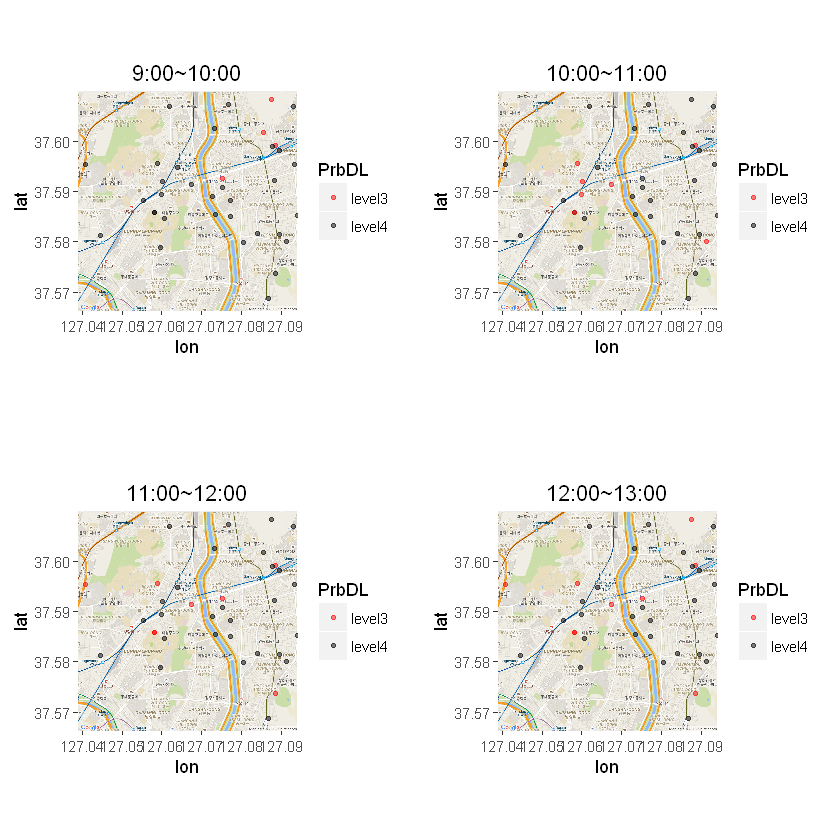

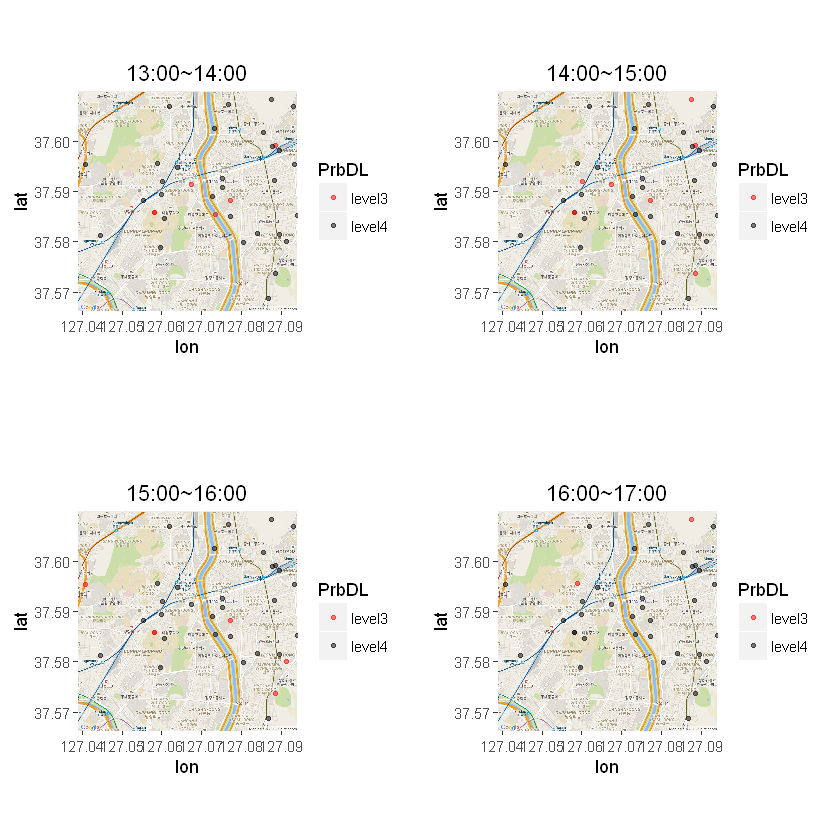

In [34]:
# for selected cells
cellList <- selGrp(stat1H, "TotPrbDLAvg_mean_max", 0.95)
#cellList <- selGrp(stat1H, "ConnNoAvg_mssmF", 0.8)

plot.H <- list()
for(i in 1:8){
        plot.H[[i]] <- showGeoDistatTime(i+8, "800", cellList)
}

grid.arrange(plot.H[[1]],plot.H[[2]],plot.H[[3]],plot.H[[4]],ncol=2)
grid.arrange(plot.H[[5]],plot.H[[6]],plot.H[[7]],plot.H[[8]],ncol=2)



In [35]:
#######################################################
gpsToPolarCoord <- function(x,y) {
        d <- complex(real = x*88.9, imaginary = y*114)
        r = Mod(d) 
        theta = Arg(d) %% (2*pi) * 360/(2*pi)
        list(r, theta)    # c(r, theta) 로 하면 df의 column을 입력으로 했을때 r값이 계속 나오고, 이어서 theta값이 계속 나옴...
}

# 해당 셀의 중심에서 1.5Km 이내에 있는 셀의 중심이 있는 셀들을 찾는 것을 default로 했음....
findNeighbor <- function(df=stat1H.1, cellidx= "1-17124-12", radiusLimit=1.5){
        x <- df[df$cellid == cellidx,"lon"]
        y <- df[df$cellid == cellidx,"lat"]
        
        polarList <-gpsToPolarCoord(df$lon-x,df$lat-y)
        df$r <- polarList[[1]]
        df$theta <- polarList[[2]]
        # 45 degree를 함(360/45 = 8개를 네이버 셀로 잡음). 네이버를 늘릴려면 30도로 할 수 있음.
        df1 <- df %>% filter(r < radiusLimit, r >0) %>% 
                group_by(theta %/% 45) %>% summarize(dist.min = min(r), cellid[which.min(r)])
        c(cellid=cellidx, neighborList=df1$cellid)
}

# 함수를 vectorize 연산할 수 있게 변형함...
findNeighborLists <-Vectorize(findNeighbor, vectorize.args = "cellidx") # vector input --> list output

stat1H.1.800 <- stat1H.1 %>% filter(str_detect(FREQUENCY, "800"))
stoavg1H.1.800 <- stoavg1H.1 %>% filter(str_detect(FREQUENCY, "800"))

neighborList.800 <-findNeighborLists(
        stat1H.1.800, stat1H.1.800$cellid, 1.5)

In [36]:
peakData <- replicate(nrow(stat1H.1.800), list())

for(i in 1:nrow(stat1H.1.800)){ 
        cellidx <- stat1H.1.800[i,"cellid"]
        peakTime <- stat1H.1.800[i,"TotPrbDLAvg_mean_which.hour"]
        peakData[[i]] <- stoavg1H.1.800 %>% 
                filter(cellid %in% neighborList.800[[cellidx]],time==peakTime) %>% 
                select(FREQUENCY, cellid, time, TotPrbDLAvg_mean) %>% 
                slice(match(neighborList.800[[cellidx]], cellid))   # tips: reorder rows by specific order...
} 


In [37]:

# peakData[[3]][,'TotPrbDLAvg_mean']
# 해당셀의 부하율이 어느정도 이상인 것을 뽑은 후에....
# 두가지 조건 설정. 인접셀보다 값이 클 것. 그리고 인접셀 평균 비율이 해당셀의 몇 % 이하일 것...
# which.max(peakData[[3]][,'TotPrbDLAvg_mean'])==1 # 해당셀이 인접셀보다 값이 큰지를 확인...
# mean(peakData[[3]][,'TotPrbDLAvg_mean'][-1])/peakData[[3]][,'TotPrbDLAvg_mean'][1]

#howtofind best value...
cellGroupValue <- function(df){
        isPeak <- which.max(df$TotPrbDLAvg_mean)==1
        heightOverMean <- df$TotPrbDLAvg_mean[1]/mean(df$TotPrbDLAvg_mean[-1])
        data.frame(cellid=df$cellid[1], 
                   time=df$time[1],
                   PrbDLAvg=df$TotPrbDLAvg_mean[1], 
                   isPeak=isPeak, 
                   heightOverMean=heightOverMean)        
}

cellGroupPeak <- do.call(rbind, lapply(peakData, cellGroupValue))
table(cellGroupPeak$isPeak)


FALSE  TRUE 
  466   151 

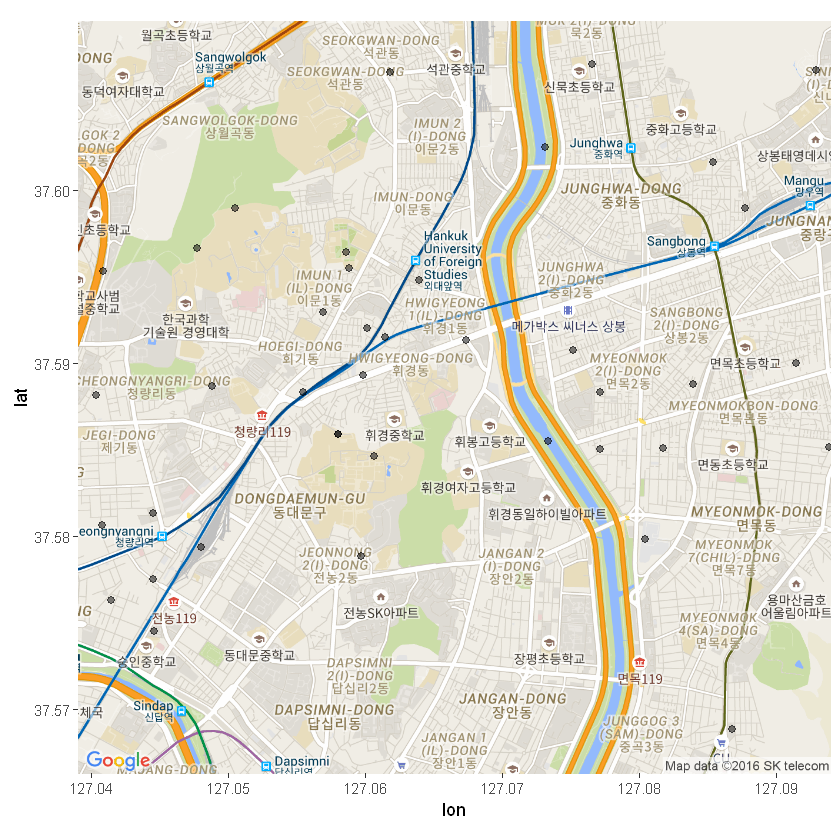

In [38]:
p.1 + geom_point(data=
                    merge(cellGroupPeak %>% 
                                filter(PrbDLAvg > 30, 
                                       isPeak==T, 
                                       heightOverMean > 2.5), 
                          cellLoc),
                 aes(lon, lat), size=2, alpha=0.5) 

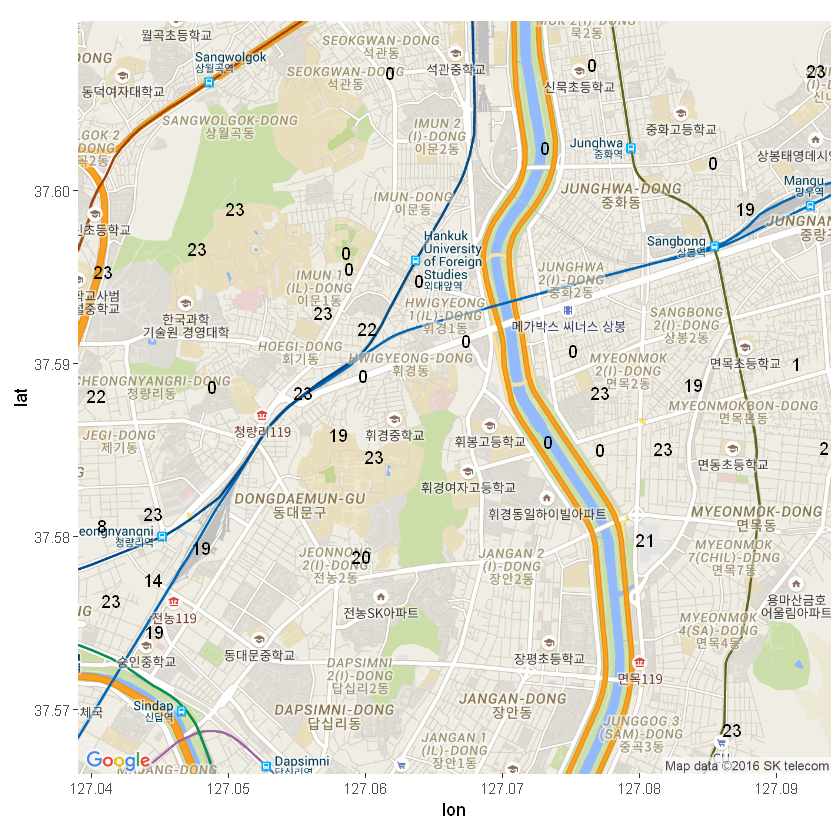

In [39]:
p.1 + geom_text(data=
                    merge(cellGroupPeak %>% 
                                filter(PrbDLAvg > 30, 
                                       isPeak==T, 
                                       heightOverMean > 2.5), 
                          cellLoc),
                aes(lon,lat,label=time), check_overlap = T)

In [40]:
##########################
#########################
# enlarge to everyhour not peakhour of the cell....

peaksData <- replicate(nrow(stat1H.1.800), list())

for(i in 1:nrow(stat1H.1.800)){
        cellidx <- stat1H.1.800[i,"cellid"]
        tmpData <- stoavg1H.1.800 %>% 
                filter(cellid %in% neighborList.800[[cellidx]]) %>% 
                select(FREQUENCY, cellid, time, TotPrbDLAvg_mean) 
        peaksData[[i]] <- lapply(split(tmpData, tmpData$time),  
                function(x) slice(x, match(neighborList.800[[cellidx]], x$cellid))) 
        
}

## converting a list of lists to a single list...
peaksDataList <- unlist(peaksData,recursive = F)
cellGroupTable <- do.call(rbind, lapply(peaksDataList, cellGroupValue))                                 


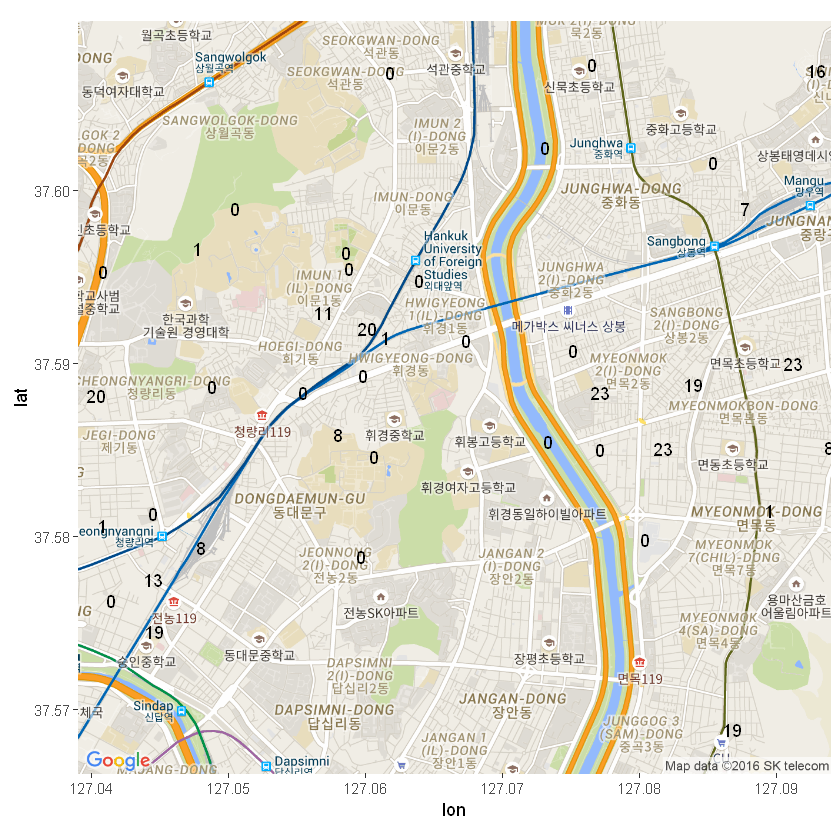

In [41]:
# 조건에 따른 피크 셀 추출...

selectedDF <- merge(cellGroupTable %>% 
                            filter(PrbDLAvg > 30, 
                                   isPeak==T, 
                                   heightOverMean > 2.5), 
                    cellLoc)

p.1 + geom_text(data=selectedDF, aes(lon,lat,label=time), check_overlap = T)



Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=37.588094,127.066465&zoom=14&size=640x640&scale=2&maptype=roadmap&language=en-EN&sensor=false


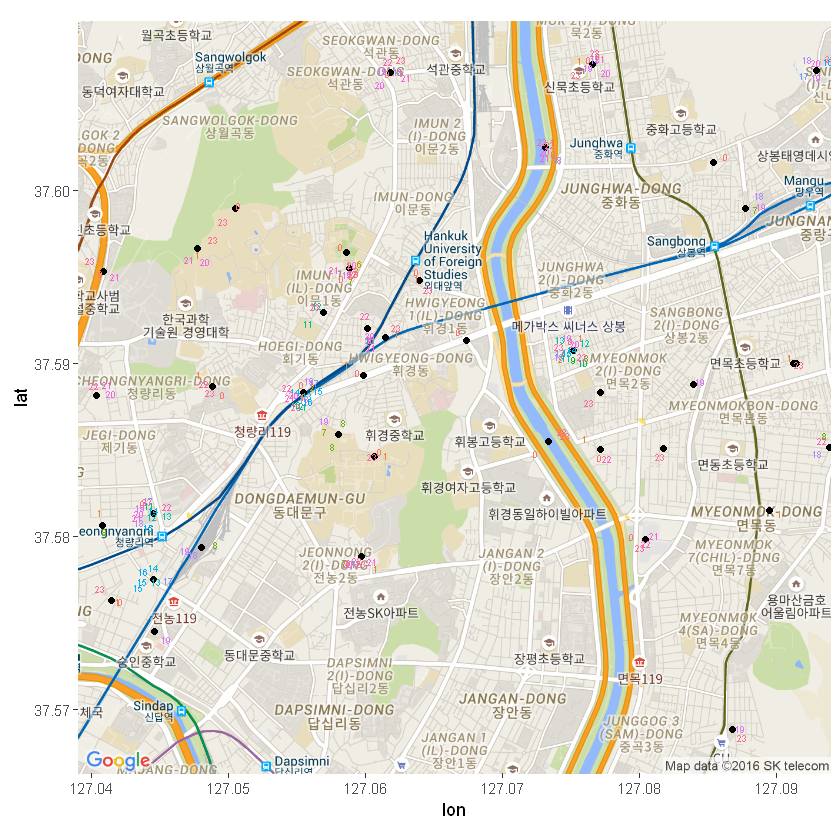

In [42]:
kor.1 <- get_map(location = c(lon = mean(cellLoc$lon), lat = mean(cellLoc$lat)),
                 maptype = "roadmap", source = "google" ,  zoom = 14) 
p.1 <- ggmap(kor.1 )  
p.1 +   geom_point(data= selectedDF, aes(lon,lat)) +
        geom_text(data= selectedDF,  
                aes(lon,lat,label=time,color=factor(time)), size=2,
                position = position_jitter(width=0.003, height=0.002)) +
                guides(color=FALSE)


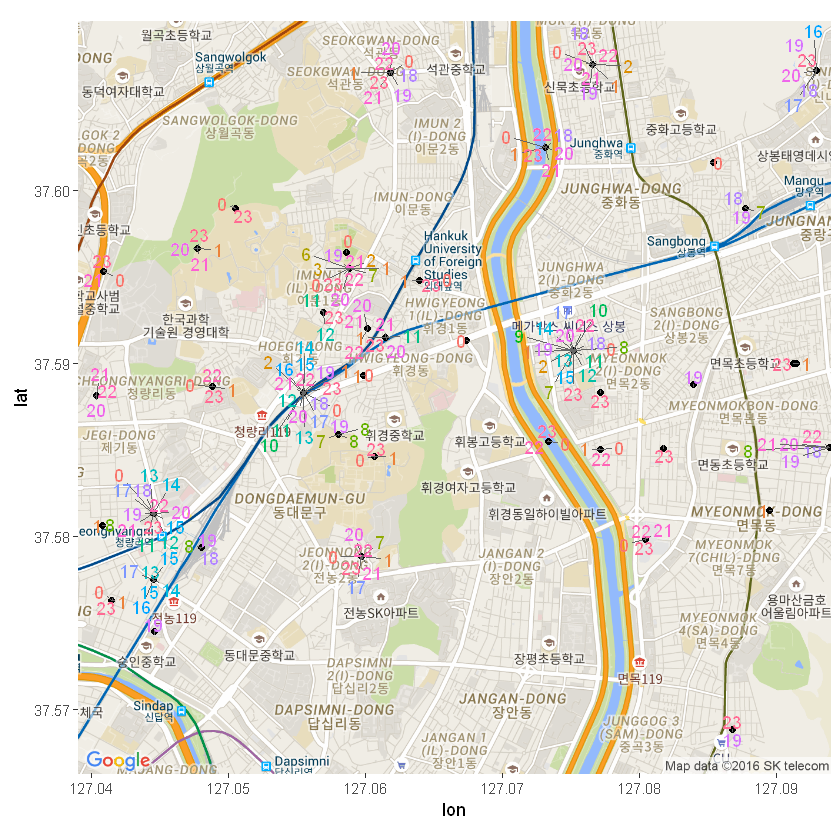

In [43]:
library(ggrepel)
p.1 +   geom_point(data= selectedDF, aes(lon,lat)) +
        geom_text_repel(data= selectedDF,  
                  aes(lon,lat,label=time,color=factor(time)), 
                  #size=2,
                  box.padding = unit(0.0005, 'lines'),
                  point.padding = unit(0.0005, 'lines'),
                  #nudge_x =0.0003, nudge_y = 0.0002,
                  show.legend = FALSE) 


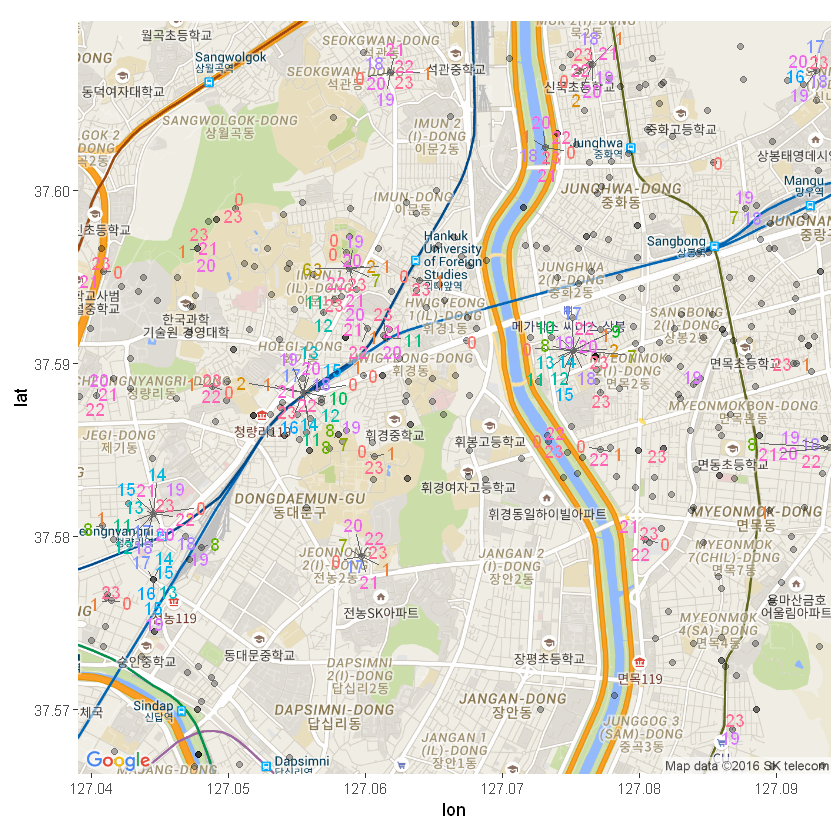

In [44]:
p.1 +   geom_point(data= stat1H.1.800, aes(lon,lat), alpha=0.3) +
        geom_text_repel(data= selectedDF,  
                  aes(lon,lat,label=time,color=factor(time)), 
                  #size=2,
                  box.padding = unit(0.0005, 'lines'),
                  point.padding = unit(0.0005, 'lines'),
                  #nudge_x =0.0003, nudge_y = 0.0002,
                  show.legend = FALSE) 
